In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Установим красивые дефолтные настройки
### Может быть лень постоянно прописывать
### У графиков параметры цвета, размера, шрифта
### Можно положить их в словарь дефолтных настроек

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

### Задача сегментации клиентов!

Сюжет: автомобильная компания провела внутреннее маркетинговое исследование и выявила, что клиенты делятся на 4 различных сегмента.

В зависимости от принадлежности к той или иной группе, различным клиентам предлагаются различные пакеты услуг, приставляются особого рода менеджеры; на этих клиентов воздействуют отличающимися друг от друга маркетинговыми интсрументами и т.д.

Данная политика показала себя успешной. Счастье клиентов стало расти, ровно как и продажи!

Теперь организация планирует выйти на новый рынок в соседнем регионе. Чтобы сразу показать конкурентам, где раки зимуют, управляющие планируют построить модель, определяющую, к какому сегменту относится тот или иной клиент. Это позволит на новом рынке лучше прощупать почву и быстрее найти нужный язык с новыми покупателями.

В качестве данных - информация о уже текущих сегментированных клиентах (на внутреннем рынке).

Сегменты бывают: A, B, C, D

Тогда задача, которую планируем решать - множественная классификация!



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 500

df = pd.read_csv("segmentation_data.csv")
df.shape

(8068, 11)

In [4]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
df['Ever_Married'].value_counts()

Yes    4643
No     3285
Name: Ever_Married, dtype: int64

Описание колонок:

1. **ID** - уникальный идентификатор клиента
2. **Gender** - пол
3. **Ever_Married** - статус замужества
4. **Age** - возраст
5. **Graduated** - дипломирован ли?
6. **Profession** - сфера деятельности
7. **Work_Experience** - опыт работы (в годах)
8. **Spending_Score** - уровень затрат
9. **Family_Size** - количество членов семьи
10. **Var_1** - анонимная категория клиента
11. **Segmentation** - сегмент клиента

**Наша целевая переменная - сегмент клиента.**

In [6]:
### Посмотрим на некатегориальные колонки

numeric_columns = df.loc[:,df.dtypes!=np.object].columns
df.loc[:,df.dtypes!=np.object].head(2)

,ID,Age,Work_Experience,Family_Size
0,462809,22,1.0,4.0
1,462643,38,NaN,3.0


In [7]:
numeric_columns

Index(['ID', 'Age', 'Work_Experience', 'Family_Size'], dtype='object')

In [8]:
### Занесем ID в индекс

df = df.set_index("ID")

numeric_columns = numeric_columns.drop("ID")

In [9]:
### Посмотрим на категориальные колонки

categorical_columns = df.loc[:,df.dtypes==np.object].columns
df.loc[:,df.dtypes==np.object].head(2)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
ID,,,,,,,
462809,Male,No,No,Healthcare,Low,Cat_4,D
462643,Female,Yes,Yes,Engineer,Average,Cat_4,A


### EDA

In [10]:
df.shape

(8068, 10)

In [11]:
### Есть ли пропуски?

df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [12]:
### Заполним средним

for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

In [13]:
### Есть ли пропуски?

df[numeric_columns].isna().sum()

Age                0
Work_Experience    0
Family_Size        0
dtype: int64

In [14]:
### Изучим корелляции вещественных признаков

df[numeric_columns].corr()

,Age,Work_Experience,Family_Size
Age,1.000000,-0.179361,-0.273291
Work_Experience,-0.179361,1.000000,-0.058702
Family_Size,-0.273291,-0.058702,1.000000


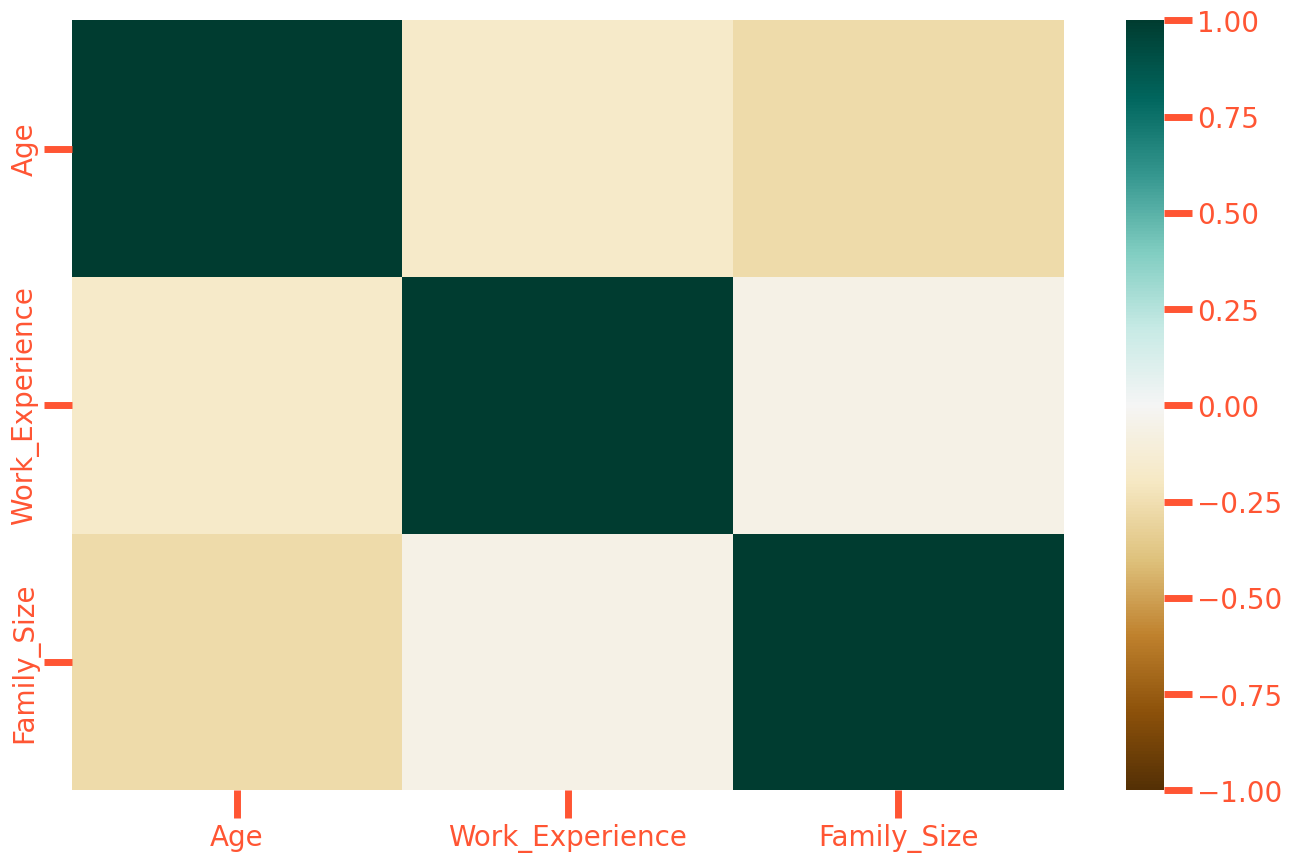

In [15]:
### Изобразим в виде Тепловой карты

import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[numeric_columns].corr(), 
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [16]:
### Секретные функции для фильтрации признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 10))

Top Absolute Correlations
Age              Family_Size        0.273291
                 Work_Experience    0.179361
Work_Experience  Family_Size        0.058702
dtype: float64


In [17]:
### Посмотрим на квазиконстантые признаки

from sklearn.feature_selection import VarianceThreshold


cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])

cutter.get_feature_names_out()

array(['Age', 'Work_Experience', 'Family_Size'], dtype=object)

In [18]:
numeric_columns

Index(['Age', 'Work_Experience', 'Family_Size'], dtype='object')

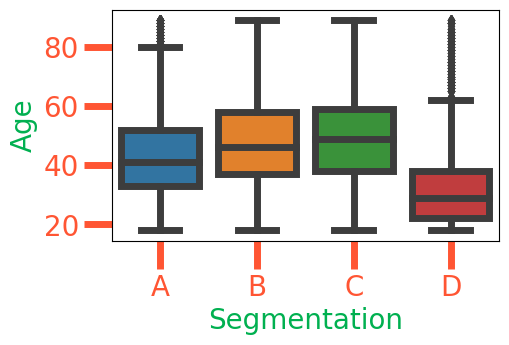

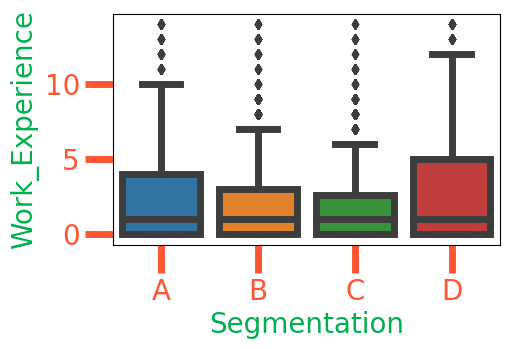

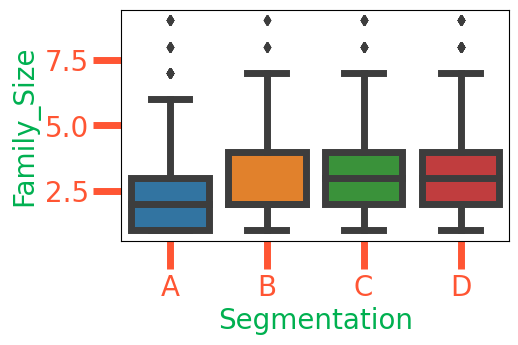

In [50]:
### Еще один способ, как в задаче классификации без построения модели
### оценить важность вещественных признаков- с помощью ящиков с усами!
### Только теперь немного "наоборот", представляя таргет как категорию
### А значения, распределение которых хотим сравнивать, окажутся нашими фичами

import seaborn as sns

for col in numeric_columns:
    
    fig = plt.figure()
    fig.set_size_inches(5, 3)
    
    sns.boxplot(y=col, x=df['Segmentation'].astype('category'), data=df)
    plt.show()

In [20]:
### Поработаем с категориальными фичами

df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


In [21]:
### Заполним  пропуски самым популярным классом

for col in categorical_columns:
    most_recent = df.groupby(col).size().sort_values().index[-1]
    df[col] = df[col].fillna(most_recent)

df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


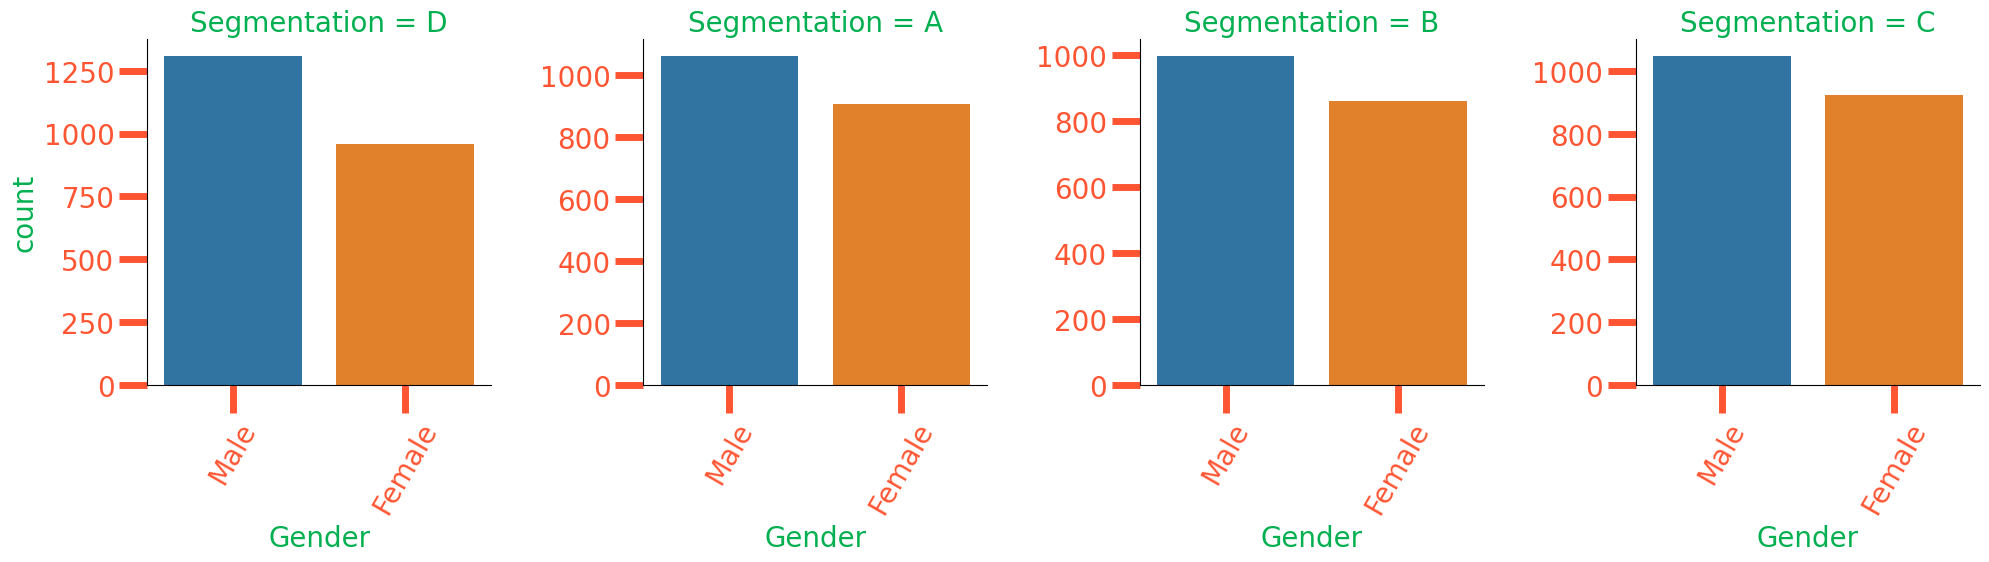

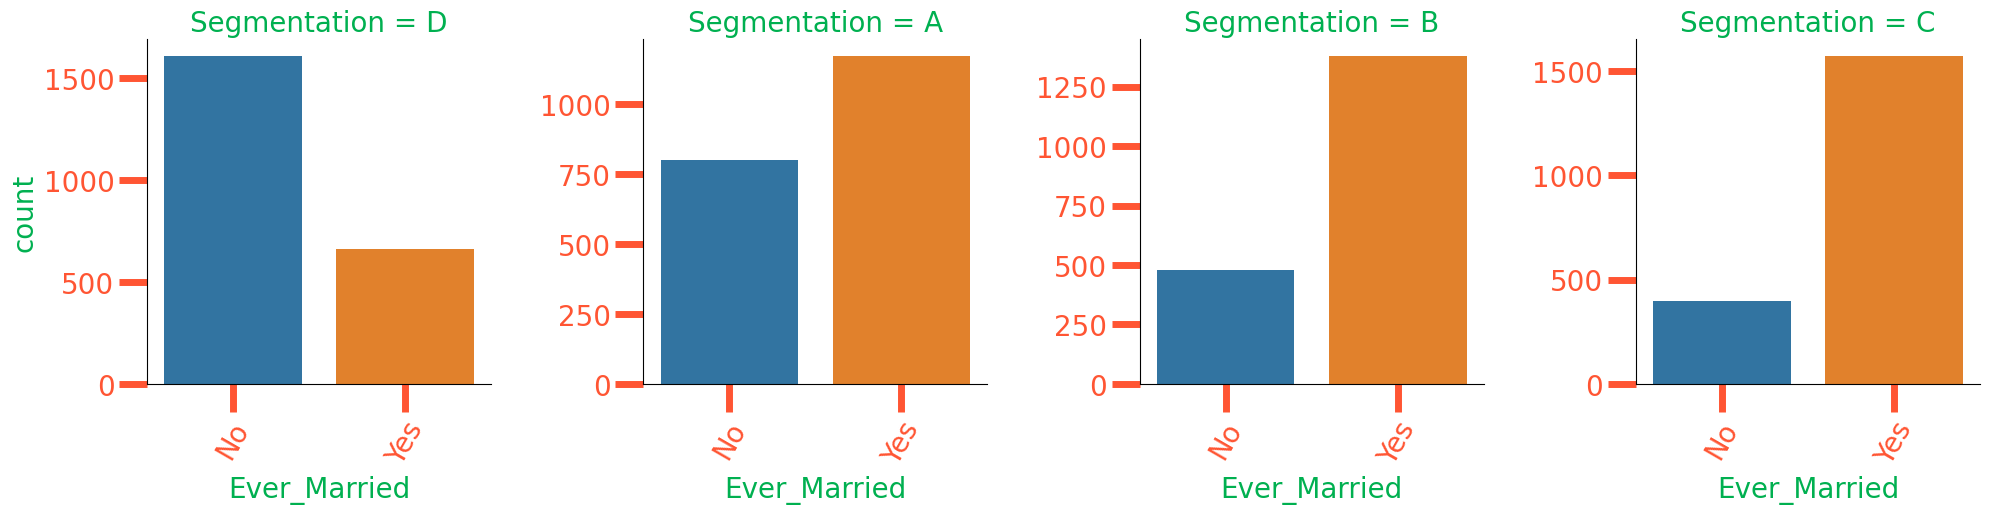

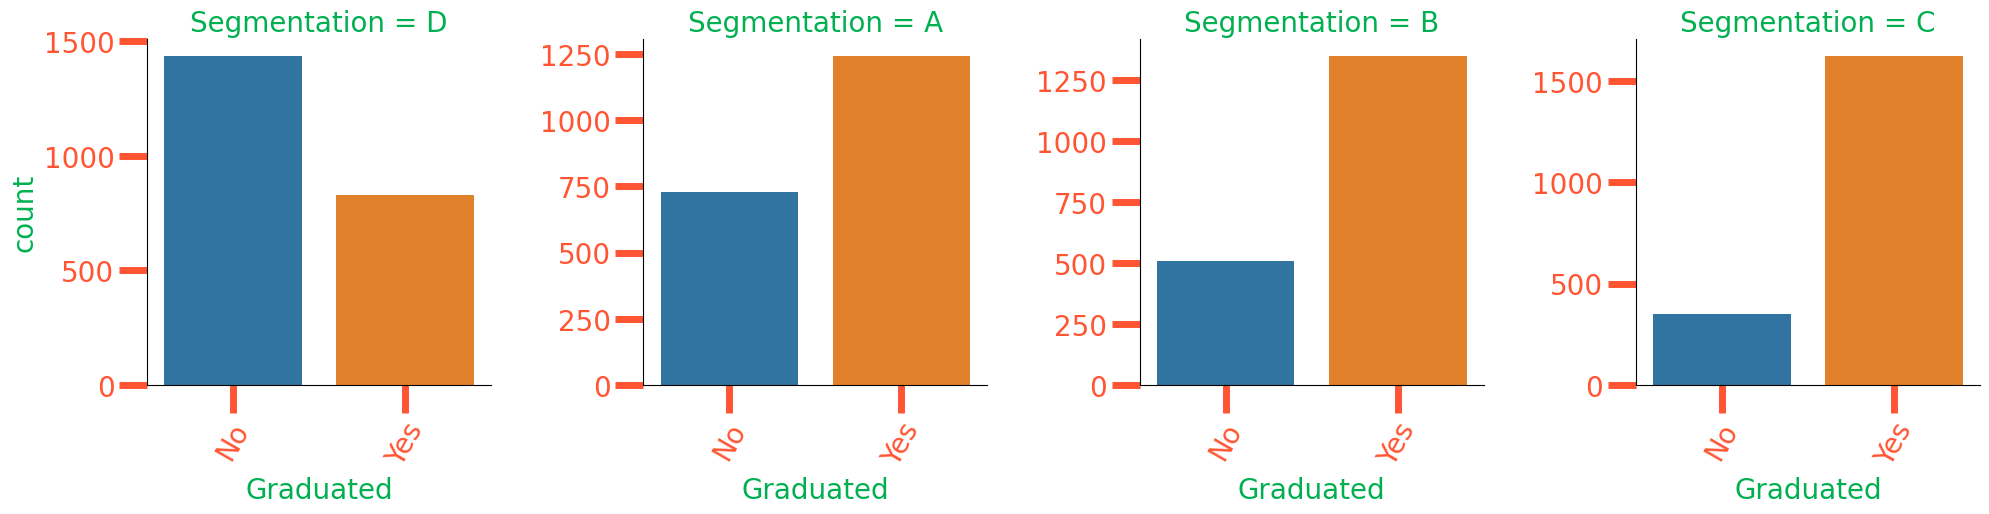

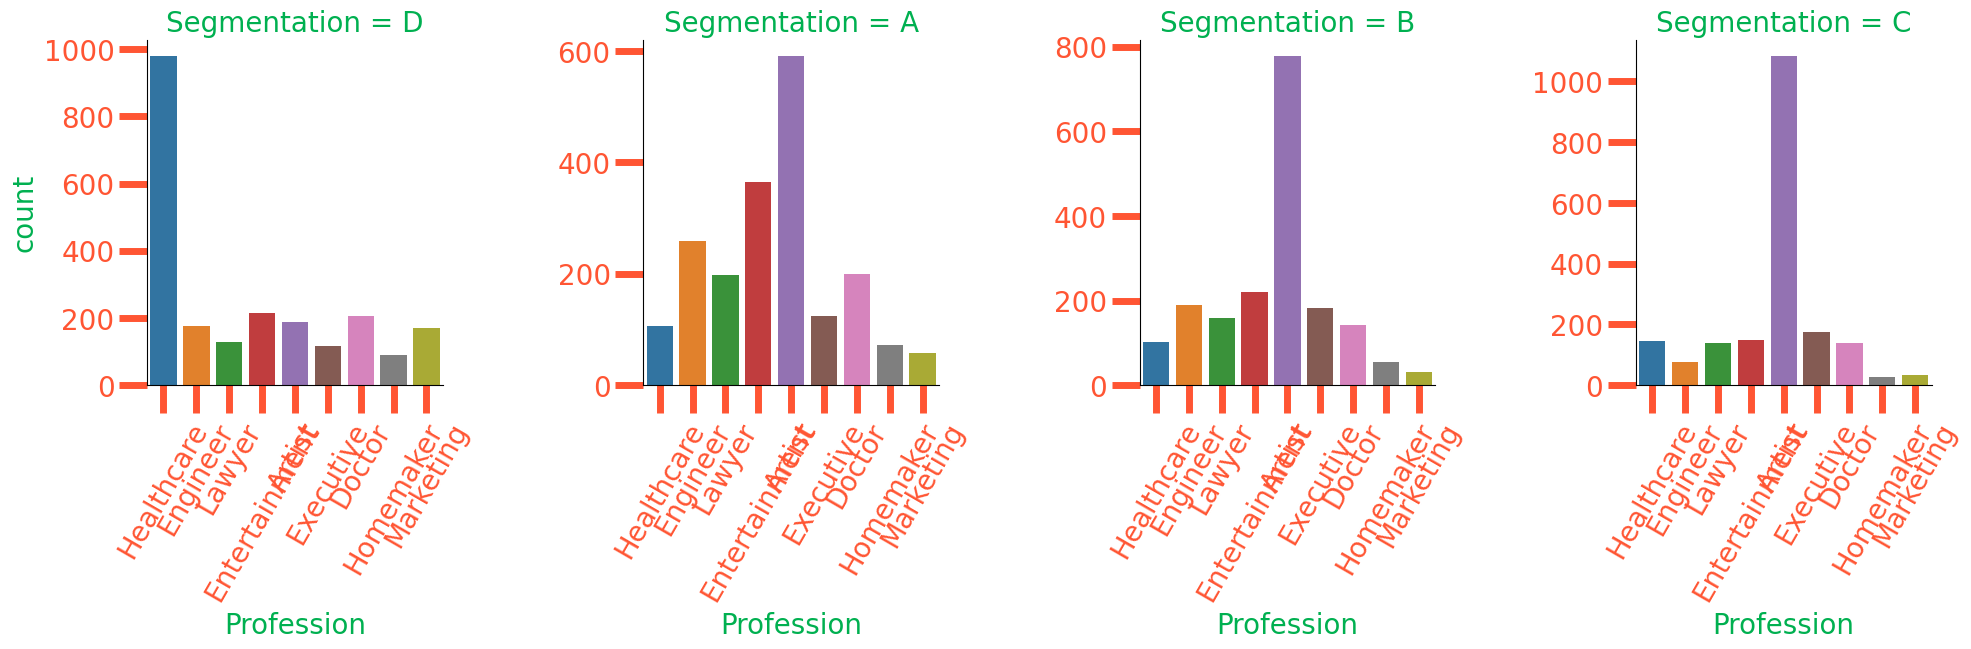

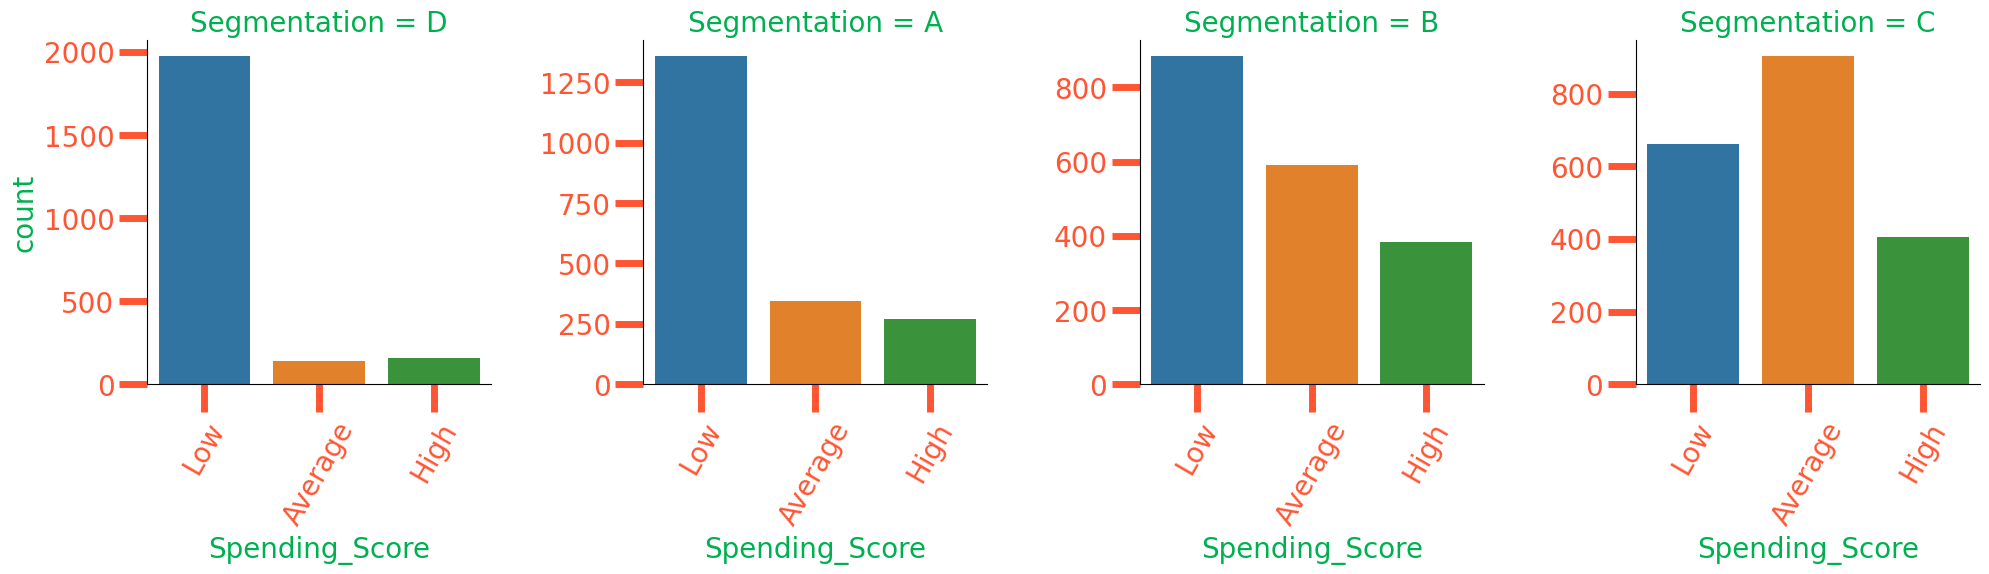

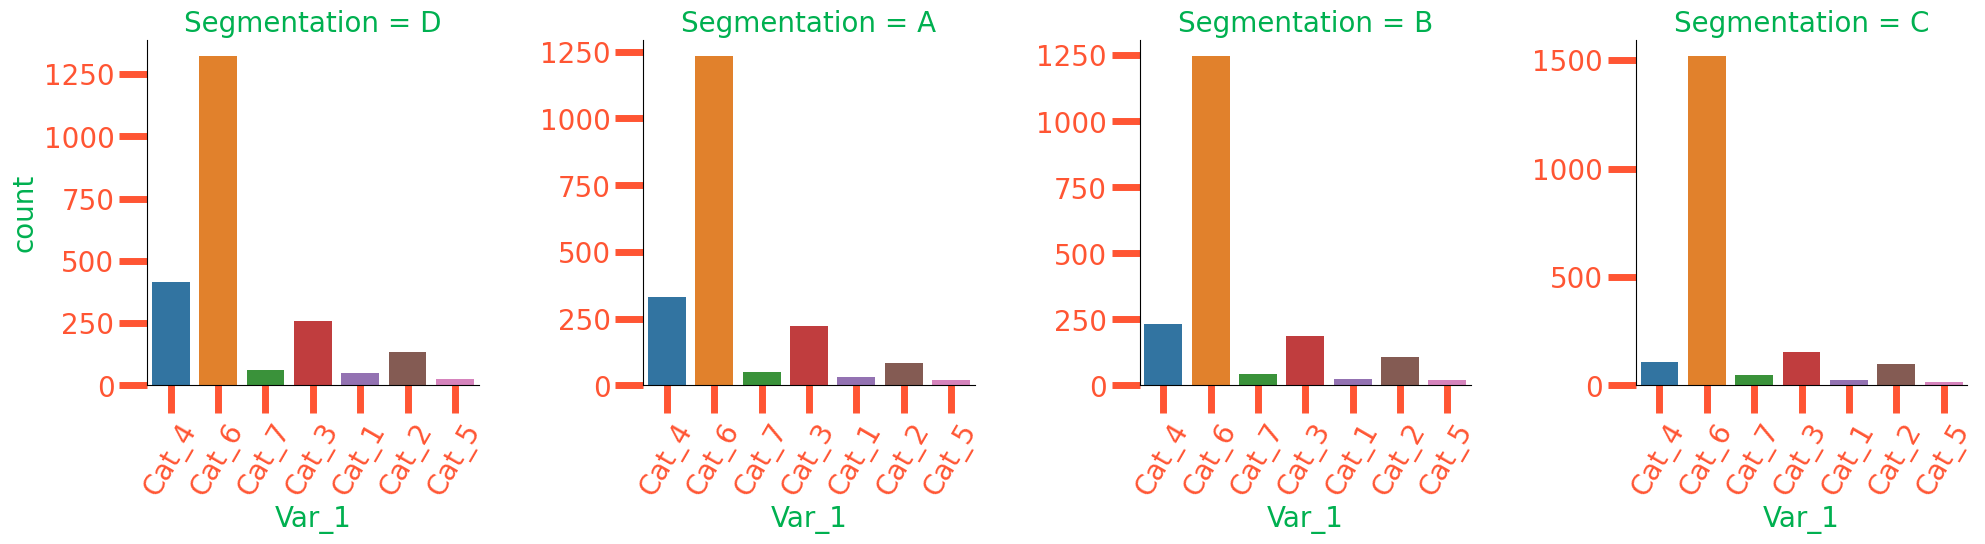

In [22]:
for col in categorical_columns: 
    if col != 'Segmentation':
        
        g = sns.catplot(x=col, kind='count', col='Segmentation', data=df, sharey=False)
        g.set_xticklabels(rotation=60)

### Закодируем категориальные фичи!

In [23]:
### Посмотрим, какие можно кодировать с помощью one-hot метода, 
### а для каких это будет жирновато

df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


### Аналог Счетчиков для multiclass problem

### Под каждый класс создадим свою бинарную колонку

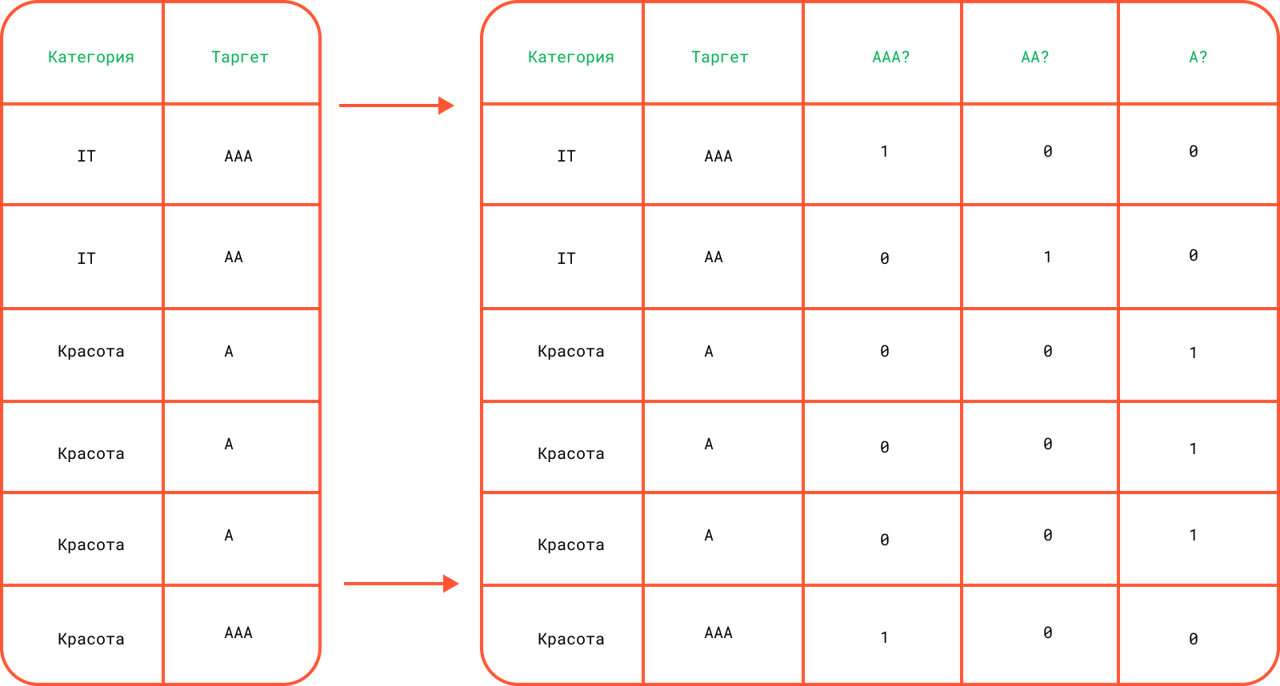

### Для каждой категории посчитаем долю единичек в каждой колонке
### Избавимся от одной, чтобы не словить мультиколлинеарность


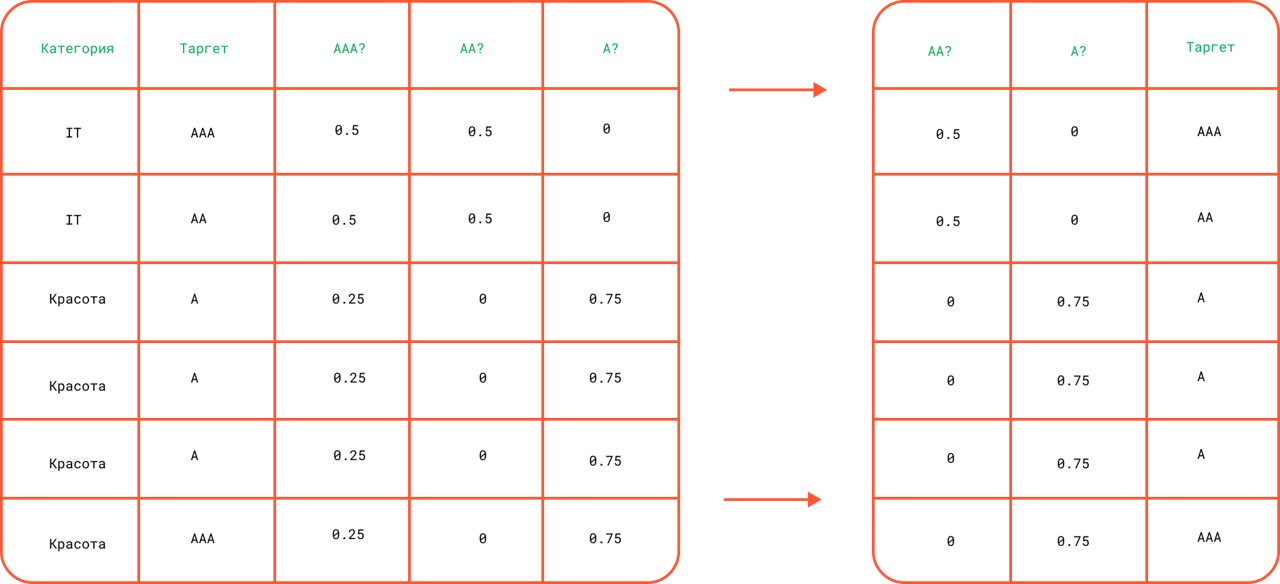

In [24]:
### Напишем функцию для такого encoding'а

def encode_multiclass_target(df, category, target='Segmentation'):
    df = df[[category, target]].copy()
    
    target_dummies = pd.get_dummies(df[target], 
                                    prefix=category, 
                                    drop_first=True)
    
    df = pd.concat((df, target_dummies), axis=1)
    
    for tg in target_dummies.columns:
        
        df[tg] = df.groupby(category)[tg].transform("mean")
    
    return df.drop(category, axis=1)

In [25]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.000000,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,2.641663,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.000000,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,2.641663,High,6.0,Cat_6,A


In [26]:
encode_multiclass_target(df, 'Gender')

,Segmentation,Gender_B,Gender_C,Gender_D
ID,,,,
462809,D,0.225719,0.237265,0.296355
462643,A,0.235826,0.252534,0.262668
466315,B,0.235826,0.252534,0.262668
461735,B,0.225719,0.237265,0.296355
462669,A,0.235826,0.252534,0.262668
...,...,...,...,...
464018,D,0.225719,0.237265,0.296355
464685,D,0.225719,0.237265,0.296355
465406,D,0.235826,0.252534,0.262668


In [27]:
df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


In [28]:
for col in categorical_columns.drop("Segmentation"):
    if df[col].nunique() < 4:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)     
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
        
    else:
        mean_target = encode_multiclass_target(df, col).drop("Segmentation", axis=1)
        df = pd.concat((df.drop(col, axis=1), mean_target), axis=1)

In [29]:
df.head()

,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
ID,,,,,,,,,,,,,,,
462809,22,1.000000,4.0,D,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084
462643,38,2.641663,3.0,A,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084
466315,67,1.000000,1.0,B,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400
461735,67,0.000000,2.0,B,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400
462669,40,2.641663,6.0,A,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400


In [30]:
X = df.drop('Segmentation', axis=1)
Y = df['Segmentation']

In [31]:
Y.head()

ID
462809    D
462643    A
466315    B
461735    B
462669    A
Name: Segmentation, dtype: object

In [32]:
### Балансированы ли классы?

Y.value_counts()

### В целом, да!

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

### Применим подход one vs all!

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    random_state=0, 
                                                    test_size=0.2)

In [34]:
from sklearn.multiclass import OneVsRestClassifier ### Один против всех
from sklearn.linear_model import SGDClassifier ### 

SGDClassifier(loss='log') ### max(0; 1-M)

pipe = Pipeline([("scaler", StandardScaler()),
                 ("one_vs_all", OneVsRestClassifier(SGDClassifier()))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all', OneVsRestClassifier(estimator=SGDClassifier()))])

In [35]:
print(pipe.classes_)

print(pipe.predict(X_test.head(1)))

print(pipe.decision_function(X_test.head(1)))

print(pipe.predict_proba(X_test.head(1)))





['A' 'B' 'C' 'D']
['C']
[[-1.10588637 -1.01855764 -0.8210256  -2.096925  ]]


AttributeError: This 'OneVsRestClassifier' has no attribute 'predict_proba'

In [36]:
X_test.head(1)

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
ID,,,,,,,,,,,,,,
467631,72,3.0,2.0,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.2484


In [37]:
### Замерим accuracy

np.mean((pipe.predict(X_test) == Y_test)), np.mean((pipe.predict(X_train) == Y_train))

(0.4541511771995043, 0.4604896188410288)

In [38]:
### Переберем различные параметры базовых моделей

from sklearn.model_selection import GridSearchCV

param_grid = {
    'one_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber',
                                    'squared_hinge', 'perceptron'],
    
    'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    
    'one_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

test_fold = [0 if x in X_train.index else -1 for x in X.index]
ps = PredefinedSplit(test_fold)

search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.49427):
{'one_vs_all__estimator__alpha': 0.001, 'one_vs_all__estimator__loss': 'log', 'one_vs_all__estimator__penalty': 'l1'}


### Применим подход all vs all!

In [39]:
from sklearn.multiclass import OneVsOneClassifier #### all vs all


pipe_all_all = Pipeline([("scaler", StandardScaler()),
                         ("all_vs_all", OneVsOneClassifier(SGDClassifier()))])

pipe_all_all.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('all_vs_all', OneVsOneClassifier(estimator=SGDClassifier()))])

In [40]:


print(pipe_all_all.classes_)

print(pipe_all_all.predict(X_test.head(1)))


['A' 'B' 'C' 'D']
['C']


In [41]:
### Переберем различные параметры базовых моделей

from sklearn.model_selection import GridSearchCV

param_grid = {
    'all_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber', 
                                    'squared_hinge', 'perceptron'],
    
    'all_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    
    'all_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

search = GridSearchCV(pipe_all_all, param_grid, cv=ps)

search.fit(X, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.49923):
{'all_vs_all__estimator__alpha': 0.5, 'all_vs_all__estimator__loss': 'hinge', 'all_vs_all__estimator__penalty': 'l2'}


In [42]:
### Помог ли нам EDA?

from sklearn.model_selection import GridSearchCV

param_grid = {
    'all_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'all_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'all_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

search = GridSearchCV(pipe_all_all, param_grid, cv=ps)

search.fit(X[numeric_columns], Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.42222):
{'all_vs_all__estimator__alpha': 0.001, 'all_vs_all__estimator__loss': 'hinge', 'all_vs_all__estimator__penalty': 'l2'}


In [43]:
### Попробуем улучшить модель полиномиальными фичами

X_polinomial = X.copy()

for col in numeric_columns:
    for power in [2, 3, 4]:
        
        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)

In [44]:
X_polinomial.head()

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D,Age_2,Age_3,Age_4,Work_Experience_2,Work_Experience_3,Work_Experience_4,Family_Size_2,Family_Size_3,Family_Size_4
ID,,,,,,,,,,,,,,,,,,,,,,,
462809,22,1.000000,4.0,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084,484,10648,234256,1.000000,1.000000,1.000000,16.0,64.0,256.0
462643,38,2.641663,3.0,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084,1444,54872,2085136,6.978385,18.434542,48.697851,9.0,27.0,81.0
466315,67,1.000000,1.0,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400,4489,300763,20151121,1.000000,1.000000,1.000000,1.0,1.0,1.0
461735,67,0.000000,2.0,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400,4489,300763,20151121,0.000000,0.000000,0.000000,4.0,8.0,16.0
462669,40,2.641663,6.0,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400,1600,64000,2560000,6.978385,18.434542,48.697851,36.0,216.0,1296.0


In [45]:
### Полиномиальные фичи

from sklearn.model_selection import GridSearchCV

param_grid = {
    'all_vs_all__estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'all_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'all_vs_all__estimator__alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

from sklearn.model_selection import PredefinedSplit

search = GridSearchCV(pipe_all_all, param_grid, cv=ps)

search.fit(X_polinomial, Y)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.50232):
{'all_vs_all__estimator__alpha': 0.01, 'all_vs_all__estimator__loss': 'hinge', 'all_vs_all__estimator__penalty': 'l2'}


In [46]:
### Макро и микро метрики

from sklearn.metrics import precision_score, recall_score, f1_score


print(f"""Precision равно: {precision_score(Y_test, 
                                            pipe_all_all.predict(X_test), 
                                            average='macro'):.3f}""" )

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe_all_all.predict(X_test),
                                      average='macro'):.3f}""" )

print(f"""F-мера равно: {f1_score(Y_test, 
                                  pipe_all_all.predict(X_test),
                                  average='macro'):.3f}""" )

Precision равно: 0.470
Recall равно: 0.484
F-мера равно: 0.459


In [47]:
### Макро и микро метрики

from sklearn.metrics import precision_score, recall_score, f1_score

print(f"""Precision равно: {precision_score(Y_test, 
                                            pipe_all_all.predict(X_test), 
                                            average='micro'):.3f}""" )

print(f"""Recall равно: {recall_score(Y_test,
                                      pipe_all_all.predict(X_test),
                                      average='micro'):.3f}""" )

print(f"""F-мера равно: {f1_score(Y_test, 
                                  pipe_all_all.predict(X_test),
                                  average='micro'):.3f}""" )

Precision равно: 0.489
Recall равно: 0.489
F-мера равно: 0.489


In [48]:
X_polinomial

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D,Age_2,Age_3,Age_4,Work_Experience_2,Work_Experience_3,Work_Experience_4,Family_Size_2,Family_Size_3,Family_Size_4
ID,,,,,,,,,,,,,,,,,,,,,,,
462809,22,1.000000,4.0,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084,484,10648,234256,1.000000,1.000000,1.000000,16.0,64.0,256.0
462643,38,2.641663,3.0,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084,1444,54872,2085136,6.978385,18.434542,48.697851,9.0,27.0,81.0
466315,67,1.000000,1.0,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400,4489,300763,20151121,1.000000,1.000000,1.000000,1.0,1.0,1.0
461735,67,0.000000,2.0,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400,4489,300763,20151121,0.000000,0.000000,0.000000,4.0,8.0,16.0
462669,40,2.641663,6.0,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400,1600,64000,2560000,6.978385,18.434542,48.697851,36.0,216.0,1296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464018,22,0.000000,7.0,1,0,0,0.294697,0.410227,0.071212,0,1,0.195489,0.195489,0.375940,484,10648,234256,0.000000,0.000000,0.000000,49.0,343.0,2401.0
464685,35,3.000000,4.0,1,0,0,0.305509,0.292154,0.193656,0,1,0.213039,0.100092,0.381084,1225,42875,1500625,9.000000,27.000000,81.000000,16.0,64.0,256.0
465406,33,1.000000,1.0,0,0,1,0.075826,0.109610,0.734985,0,1,0.234287,0.285472,0.248400,1089,35937,1185921,1.000000,1.000000,1.000000,1.0,1.0,1.0
